Section 1: Simulating wigner rotation as a Unitary gate

This section is inspired by foundational paper on relativistic quantum information and tries to simulate the below circuit from the paper:

In [ ]:
from qiskit.visualization import circuit_drawer

circuit_drawer(circuit, output='mpl', filename='circuit.png')

Wigner rotation as unitary gate (calculated using classical parameters) 

In [18]:
import numpy as np
from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
import pandas as pd

In [19]:
# -----------------------------
# Configuration Parameters
# -----------------------------
velocities = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
momentum_directions = {
    'A': np.array([0, 0, 1]),
    'B': np.array([1, 0, 0]),
    'C': np.array([0, 1, 0]),
    'D': np.array([1, 1, 0]),
    'E': np.array([1, 0, 1]),
    'F': np.array([0, 1, 1])
}

In [20]:
boost_direction = np.array([0, 0, 1])  # boost direction (z-axis)


In [21]:
for key in momentum_directions:
    momentum_directions[key] = momentum_directions[key] / np.linalg.norm(momentum_directions[key])

In [22]:
# Pauli matrices
sigma = [
    np.array([[0, 1], [1, 0]]),   # σ_x
    np.array([[0, -1j], [1j, 0]]),# σ_y
    np.array([[1, 0], [0, -1]])   # σ_z
]

In [23]:
# Setup simulators
state_backend = AerSimulator(method='statevector')  # for Bloch vector extraction
qasm_backend = AerSimulator()  # for measurement outcomes

/var/folders/c8/gcpq5wfj6vqf9rqk1jhxvqq80000gn/T/ipykernel_64515/184624467.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = qasm_backend.run(qobj).result()
/var/folders/c8/gcpq5wfj6vqf9rqk1jhxvqq80000gn/T/ipykernel_64515/184624467.py:39: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = state_backend.run(assemble(tqc_state)).result()


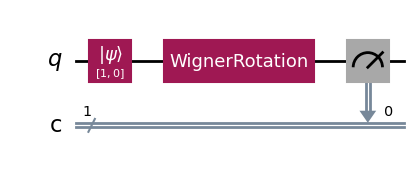

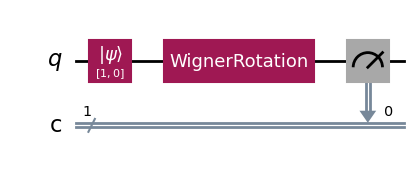

In [37]:
results = []

# -----------------------------
# Simulation Loop
# -----------------------------
for v in velocities:
    eta = np.arctanh(v)  # compute rapidity
    for label, p_vec in momentum_directions.items():
        # Compute Wigner angle
        cos_alpha = np.dot(boost_direction, p_vec)
        sin_alpha = np.sqrt(1 - cos_alpha**2)
        theta = 2 * np.arctan2(np.sinh(eta) * sin_alpha, np.cosh(eta) + np.sinh(eta) * cos_alpha)

        # Compute rotation axis (Wigner)
        n = np.cross(boost_direction, p_vec)
        n_hat = n / np.linalg.norm(n) if np.linalg.norm(n) != 0 else np.array([0, 0, 1])

        # Build Wigner rotation unitary
        rotation_generator = sum(n_hat[i] * sigma[i] for i in range(3))
        U_wigner = expm(-1j * theta / 2 * rotation_generator)
         # Build quantum circuit
        qc=QuantumCircuit(1, 1)
        qc.initialize([1, 0], 0)  # |0⟩
        qc.append(UnitaryGate(U_wigner, label="WignerRotation"), [0])
        qc.measure(0, 0)

        # Simulate for measurement outcome
        transpiled_qc = transpile(qc, qasm_backend)
        qobj = assemble(transpiled_qc)
        result = qasm_backend.run(qobj).result()
        counts = result.get_counts()

        # Simulate for statevector and Bloch vector
        qc_state = QuantumCircuit(1)
        qc_state.initialize([1, 0], 0)
        qc_state.append(UnitaryGate(U_wigner), [0])
        qc_state.save_statevector() 
        tqc_state = transpile(qc_state, state_backend)
        result = state_backend.run(assemble(tqc_state)).result()
        state = result.get_statevector(tqc_state)
        bloch = [2 * np.real(state[0] * np.conj(state[1])),   # x
         2 * np.imag(state[1] * np.conj(state[0])),   # y
         np.abs(state[0])**2 - np.abs(state[1])**2]   # z
        results.append({
            'velocity': v,
            'momentum_label': label,
            'momentum_vector': p_vec.tolist(),
            'theta_rad': round(theta, 4),
            'rotation_axis': n_hat.tolist(),
            'P(|0>)': counts.get('0', 0) / 1024,
            'P(|1>)': counts.get('1', 0) / 1024,
            'bloch_x': bloch[0],
            'bloch_y': bloch[1],
            'bloch_z': bloch[2]
        })
         # Plot Bloch vectors of both qubits
    fig = plot_bloch_multivector(state)
    plt.show()
qc.draw(output = "mpl")

In [28]:
df = pd.DataFrame(results)
df.to_csv("wigner_rotation_results.csv", index=False)
print("Simulation completed and results saved to 'wigner_rotation_results.csv'")

Simulation completed and results saved to 'wigner_rotation_results.csv'


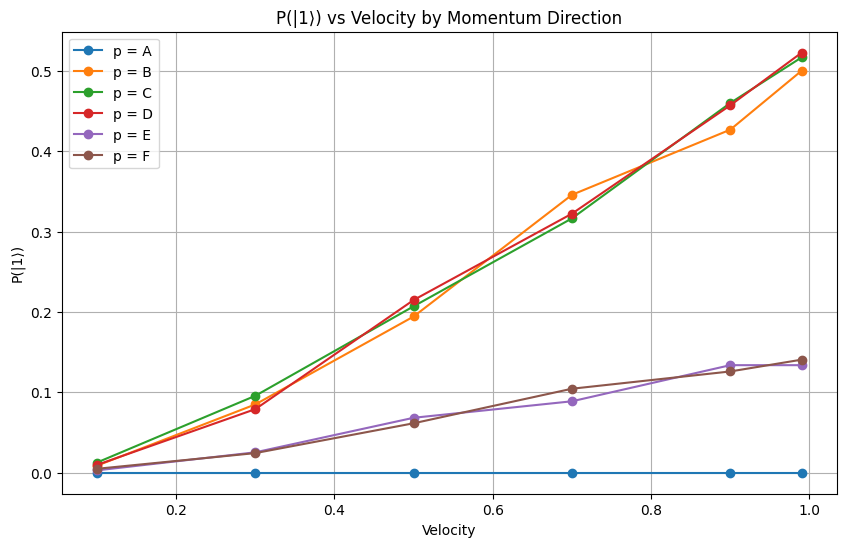

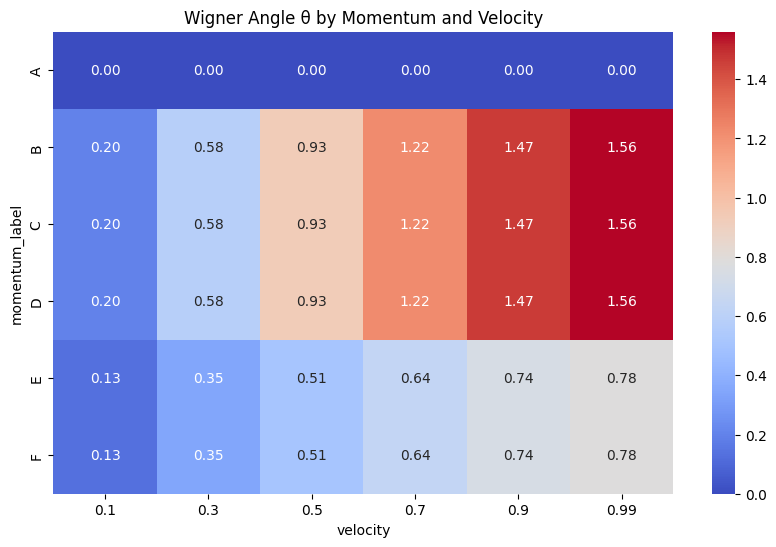

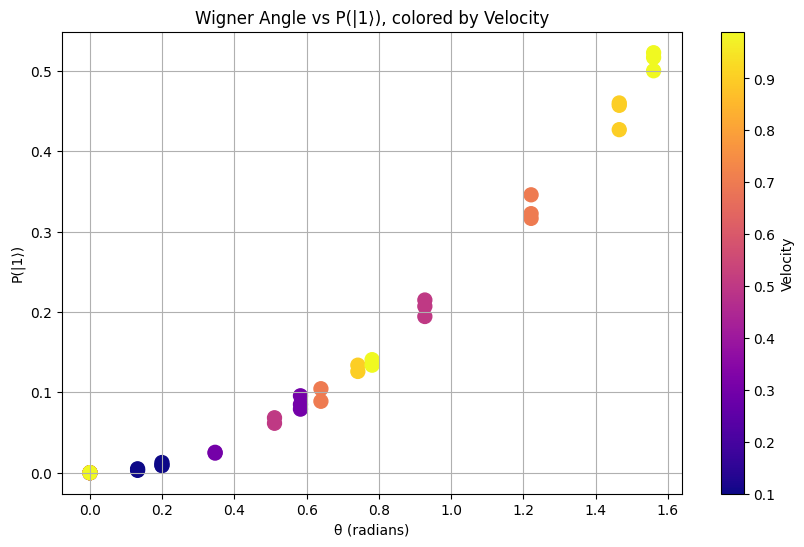

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load your result CSV
df = pd.read_csv("wigner_rotation_results.csv")

# Probability vs Velocity Plot
plt.figure(figsize=(10, 6))
for label in df['momentum_label'].unique():
    sub = df[df['momentum_label'] == label]
    plt.plot(sub['velocity'], sub['P(|1>)'], marker='o', label=f'p = {label}')
plt.title("P(|1⟩) vs Velocity by Momentum Direction")
plt.xlabel("Velocity")
plt.ylabel("P(|1⟩)")
plt.legend()
plt.grid(True)
plt.show()

# Heatmap of Wigner Rotation Angles
pivot = df.pivot(index='momentum_label', columns='velocity', values='theta_rad')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Wigner Angle θ by Momentum and Velocity")
plt.show()

# Scatter: Theta vs P(|1⟩)
plt.figure(figsize=(10, 6))
plt.scatter(df['theta_rad'], df['P(|1>)'], c=df['velocity'], cmap='plasma', s=100)
plt.title("Wigner Angle vs P(|1⟩), colored by Velocity")
plt.xlabel("θ (radians)")
plt.ylabel("P(|1⟩)")
plt.colorbar(label='Velocity')
plt.grid(True)
plt.show()

Wigner rotation as controlled gate

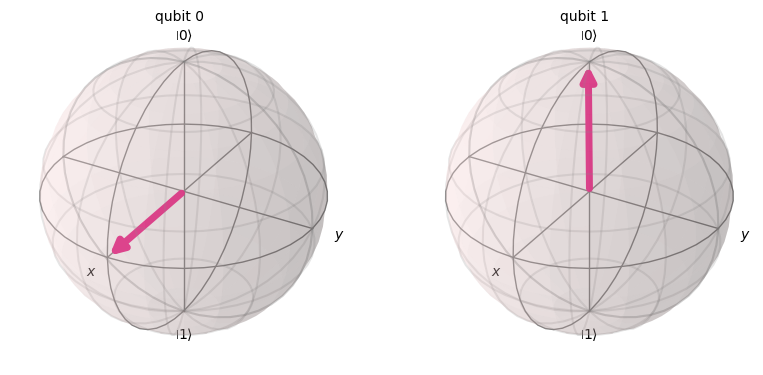

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.70701955+0.j, 0.        +0.j,
             0.01110675+0.j],
            dims=(2, 2))


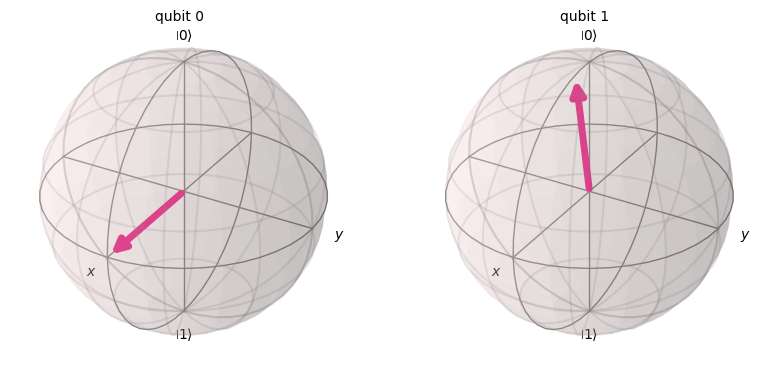

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.69481217+0.j, 0.        +0.j,
             0.13128612+0.j],
            dims=(2, 2))


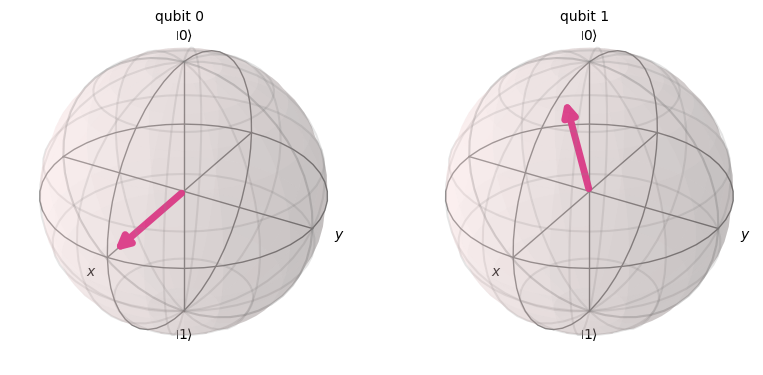

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.66232726+0.j, 0.        +0.j,
             0.24763401+0.j],
            dims=(2, 2))


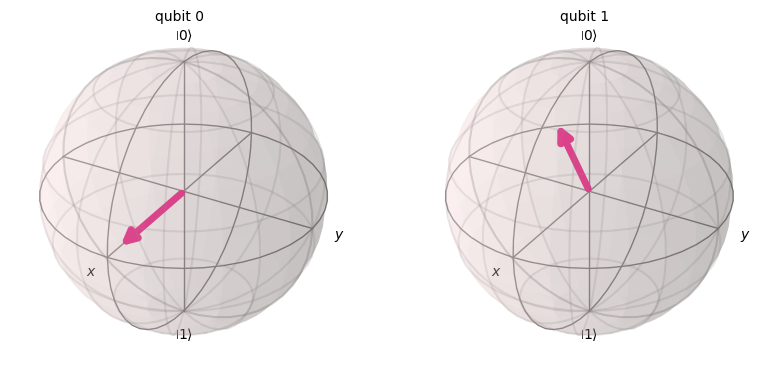

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.61051285+0.j, 0.        +0.j,
             0.3567549 +0.j],
            dims=(2, 2))


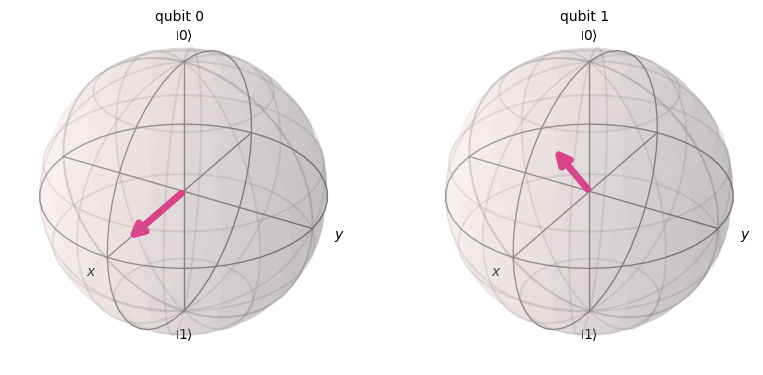

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.54088111+0.j, 0.        +0.j,
             0.45546419+0.j],
            dims=(2, 2))


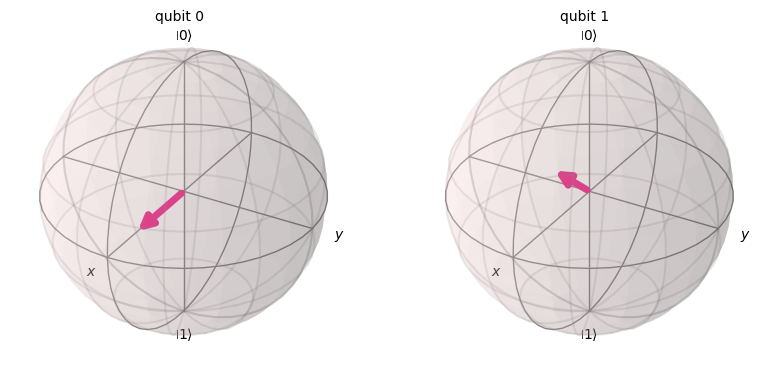

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.45546419+0.j, 0.        +0.j,
             0.54088111+0.j],
            dims=(2, 2))


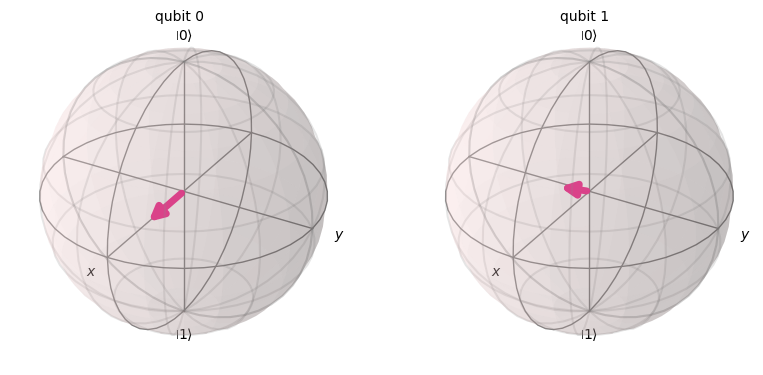

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.3567549 +0.j, 0.        +0.j,
             0.61051285+0.j],
            dims=(2, 2))


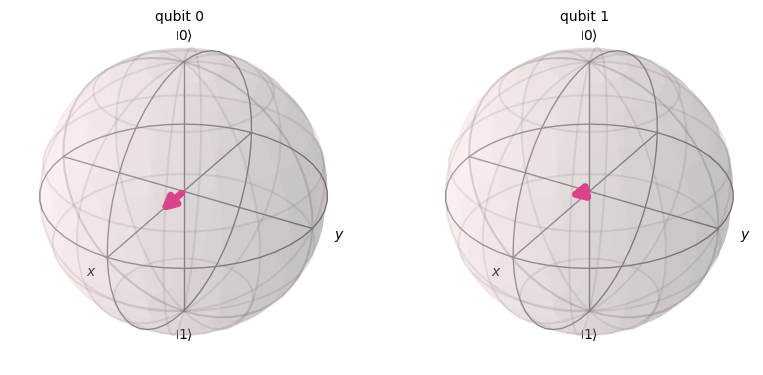

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.24763401+0.j, 0.        +0.j,
             0.66232726+0.j],
            dims=(2, 2))


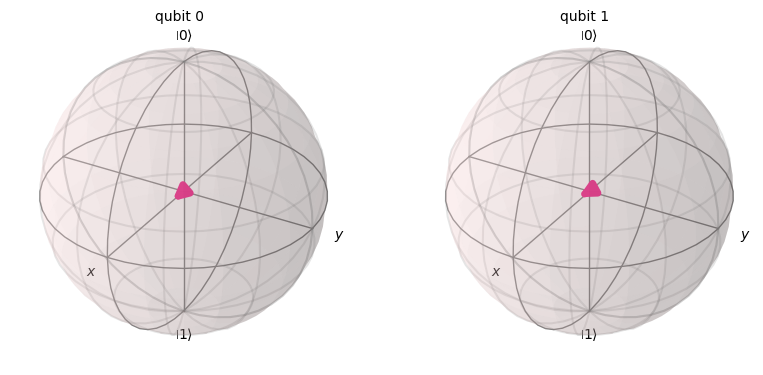

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.13128612+0.j, 0.        +0.j,
             0.69481217+0.j],
            dims=(2, 2))


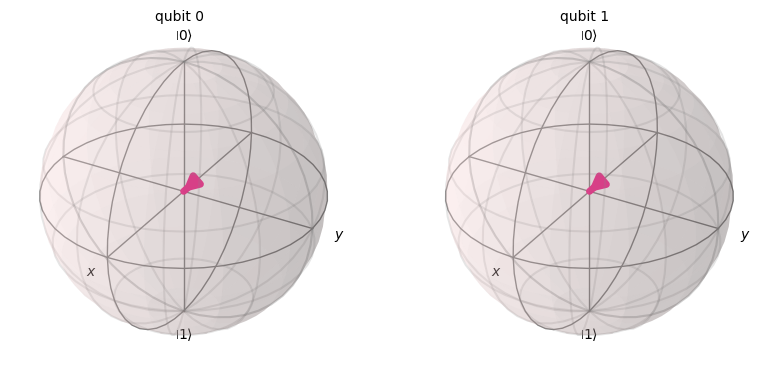

Quantum Statevector:
 Statevector([0.70710678+0.j, 0.01110675+0.j, 0.        +0.j,
             0.70701955+0.j],
            dims=(2, 2))


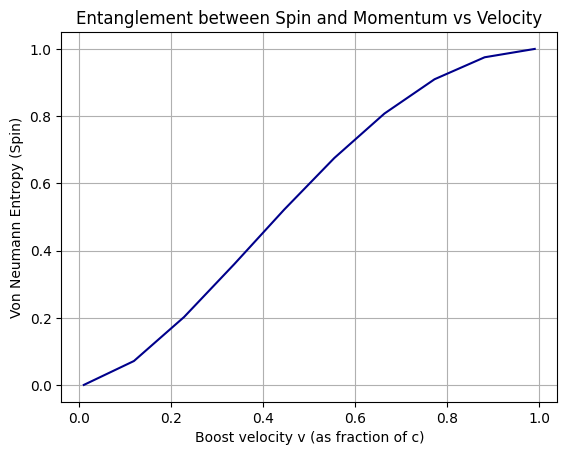

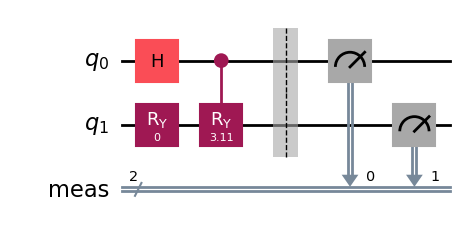

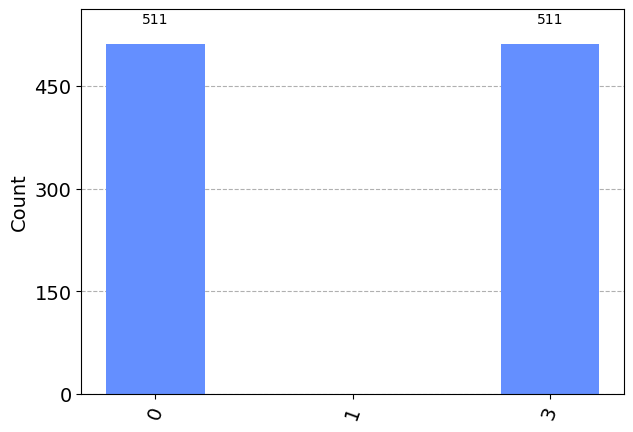

In [48]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, entropy
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
import numpy as np
%matplotlib inline

velocities = np.linspace(0.01, 0.99, 10)
entropies = []
for v in velocities:
    Omega_p1 = 0
    Omega_p2 = np.pi * v  # Wigner angle grows with velocity

    # Quantum circuit with 2 qubits: momentum and spin
    qc = QuantumCircuit(2)
    qc.h(0)  # momentum qubit: (|0> + |1>)/√2

    # Apply rotation Ry(Omega_p1) to spin qubit (unconditional)
    qc.ry(Omega_p1, 1)

    # Apply controlled Ry(Omega_p2 - Omega_p1) if momentum is |1⟩
    qc.cry(Omega_p2 - Omega_p1, 0, 1)

    # Get full 2-qubit state
    state = Statevector.from_instruction(qc)

    # Trace out momentum qubit to get reduced spin state
    reduced_spin = partial_trace(state, [0])

    # Compute entropy of spin to quantify entanglement
    S = entropy(reduced_spin, base=2)
    entropies.append(S)
    # Plot Bloch vectors of both qubits
    fig = plot_bloch_multivector(state)
    plt.show()
    qc.measure_all()
    sampler = Sampler()
    job = sampler.run(qc)
    result = job.result()
  
    # Print the amplitudes
    print("Quantum Statevector:\n", state)



plt.plot(velocities, entropies, color='darkblue')
plt.xlabel("Boost velocity v (as fraction of c)")
plt.ylabel("Von Neumann Entropy (Spin)")
plt.title("Entanglement between Spin and Momentum vs Velocity")
plt.grid(True)
plt.show()
qc.draw(output = "mpl")

# Get probabilities
quasi_dist = result.quasi_dists[0]
counts = {k: int(v * 1024) for k, v in quasi_dist.items()}  # scale to 1024 shots

# Plot histogram
plot_histogram(counts)
plt.show()


Quantum Entanglement of moving bodies

In [116]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import partial_trace, DensityMatrix, concurrence
from qiskit.visualization import plot_bloch_vector
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

In [117]:
velocities = np.linspace(0.01, 0.99, 10)
concurrence_values = []
entropies = []
boost_direction = np.array([0, 0, 1]) # z-direction boost
# Define 4 discrete momentum eigenstates (2 per qubit)
momentum_vectors = {
    'p1': np.array([1, 0.3, 1], dtype=float),
    'p2': np.array([0, 0.6, 1], dtype=float),
    'p3': np.array([1, 1, 0.5], dtype=float),
    'p4': np.array([0.7, 0, 1], dtype=float)
}


v = 0.01, p1 → θ = 0.014344 rad
v = 0.01, p2 → θ = 0.010202 rad
v = 0.01, p3 → θ = 0.018793 rad
v = 0.01, p4 → θ = 0.011376 rad
DensityMatrix([[ 4.99996757e-01+0.j, -7.02819469e-04+0.j,
                 7.02819469e-04+0.j,  4.99996757e-01+0.j],
               [-7.02819469e-04+0.j,  3.24309240e-06+0.j,
                -3.24309240e-06+0.j, -7.02819469e-04+0.j],
               [ 7.02819469e-04+0.j, -3.24309240e-06+0.j,
                 3.24309240e-06+0.j,  7.02819469e-04+0.j],
               [ 4.99996757e-01+0.j, -7.02819469e-04+0.j,
                 7.02819469e-04+0.j,  4.99996757e-01+0.j]],
              dims=(2, 2))


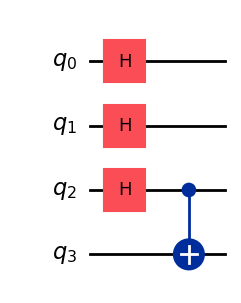

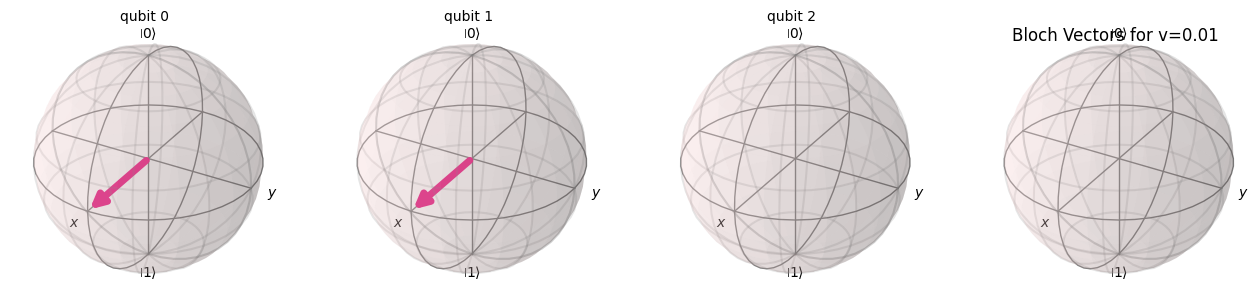

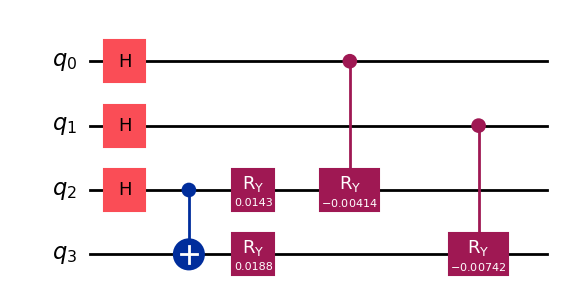

Quantum Statevector:
 Statevector([ 3.53552516e-01+0.j,  3.53550129e-01+0.j,  3.53553001e-01+0.j,
              3.53553330e-01+0.j, -7.86483714e-04+0.j, -1.51862047e-03+0.j,
              5.24677850e-04+0.j, -2.07462726e-04+0.j,  7.86483714e-04+0.j,
              1.51862047e-03+0.j, -5.24677850e-04+0.j,  2.07462726e-04+0.j,
              3.53552516e-01+0.j,  3.53550129e-01+0.j,  3.53553001e-01+0.j,
              3.53553330e-01+0.j],
            dims=(2, 2, 2, 2))
v = 0.12, p1 → θ = 0.158336 rad
v = 0.12, p2 → θ = 0.110904 rad
v = 0.12, p3 → θ = 0.214804 rad
v = 0.12, p4 → θ = 0.124095 rad
DensityMatrix([[ 4.99521264e-01+0.j, -8.69416883e-03+0.j,
                 8.69416883e-03+0.j,  4.99521264e-01+0.j],
               [-8.69416883e-03+0.j,  4.78735970e-04+0.j,
                -4.78735970e-04+0.j, -8.69416883e-03+0.j],
               [ 8.69416883e-03+0.j, -4.78735970e-04+0.j,
                 4.78735970e-04+0.j,  8.69416883e-03+0.j],
               [ 4.99521264e-01+0.j, -8.69416883e-03+

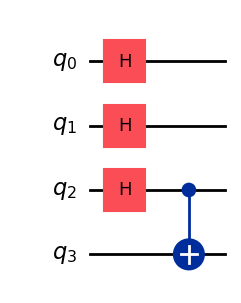

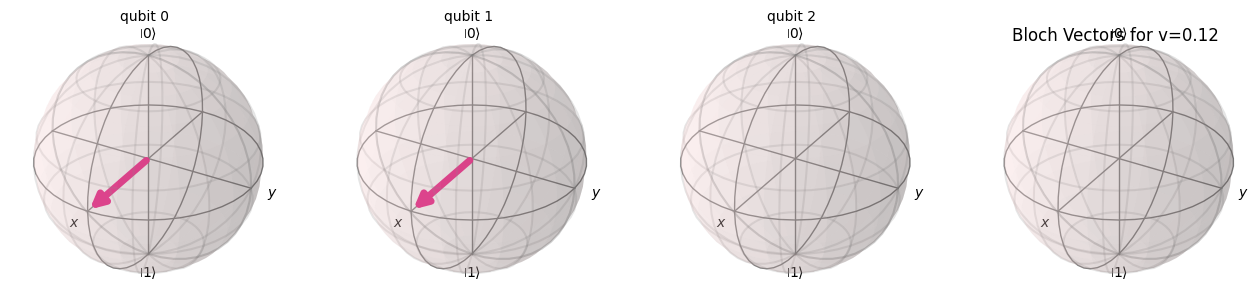

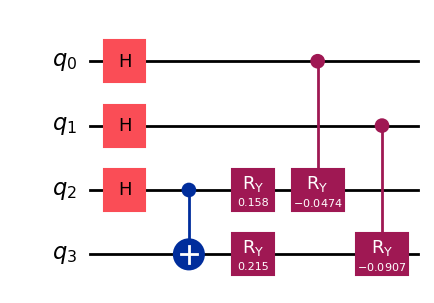

Quantum Statevector:
 Statevector([ 0.35341248+0.j,  0.35307641+0.j,  0.35350158+0.j,
              0.3535457 +0.j, -0.00998083+0.j, -0.01835881+0.j,
              0.00605275+0.j, -0.00233185+0.j,  0.00998083+0.j,
              0.01835881+0.j, -0.00605275+0.j,  0.00233185+0.j,
              0.35341248+0.j,  0.35307641+0.j,  0.35350158+0.j,
              0.3535457 +0.j],
            dims=(2, 2, 2, 2))
v = 0.23, p1 → θ = 0.282320 rad
v = 0.23, p2 → θ = 0.195458 rad
v = 0.23, p3 → θ = 0.394015 rad
v = 0.23, p4 → θ = 0.219278 rad
DensityMatrix([[ 0.49824067+0.j, -0.01684602+0.j,  0.01684602+0.j,
                 0.49824067+0.j],
               [-0.01684602+0.j,  0.00175933+0.j, -0.00175933+0.j,
                -0.01684602+0.j],
               [ 0.01684602+0.j, -0.00175933+0.j,  0.00175933+0.j,
                 0.01684602+0.j],
               [ 0.49824067+0.j, -0.01684602+0.j,  0.01684602+0.j,
                 0.49824067+0.j]],
              dims=(2, 2))


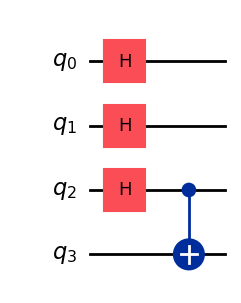

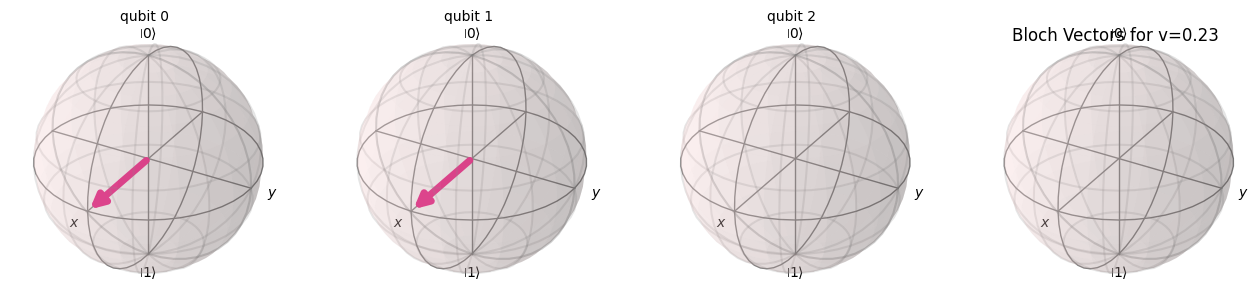

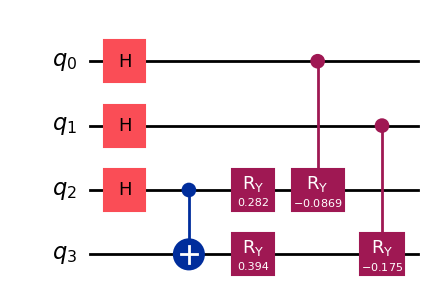

Quantum Statevector:
 Statevector([ 0.35300217+0.j,  0.35181248+0.j,  0.35337777+0.j,
              0.35352832+0.j, -0.01973488+0.j, -0.03504256+0.j,
              0.01114236+0.j, -0.00421074+0.j,  0.01973488+0.j,
              0.03504256+0.j, -0.01114236+0.j,  0.00421074+0.j,
              0.35300217+0.j,  0.35181248+0.j,  0.35337777+0.j,
              0.35352832+0.j],
            dims=(2, 2, 2, 2))
v = 0.34, p1 → θ = 0.389415 rad
v = 0.34, p2 → θ = 0.267220 rad
v = 0.34, p3 → θ = 0.555992 rad
v = 0.34, p4 → θ = 0.300377 rad
DensityMatrix([[ 0.4962651 +0.j, -0.02467582+0.j,  0.02467582+0.j,
                 0.4962651 +0.j],
               [-0.02467582+0.j,  0.0037349 +0.j, -0.0037349 +0.j,
                -0.02467582+0.j],
               [ 0.02467582+0.j, -0.0037349 +0.j,  0.0037349 +0.j,
                 0.02467582+0.j],
               [ 0.4962651 +0.j, -0.02467582+0.j,  0.02467582+0.j,
                 0.4962651 +0.j]],
              dims=(2, 2))


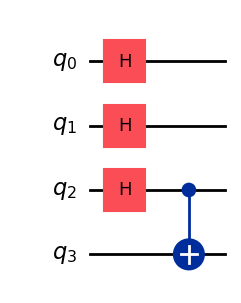

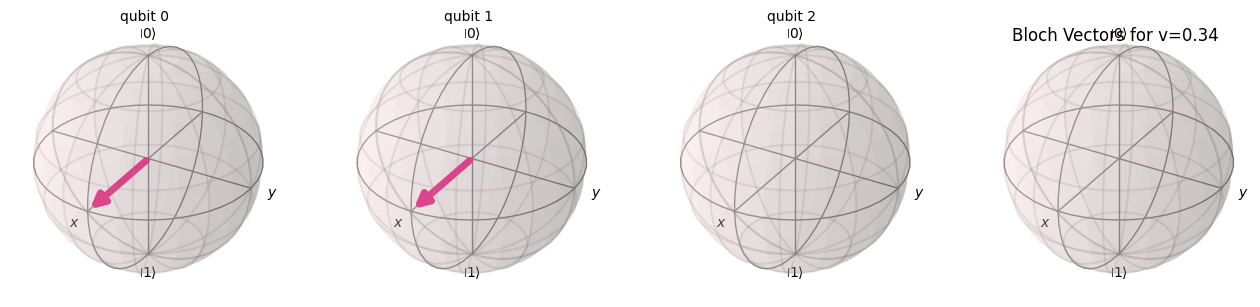

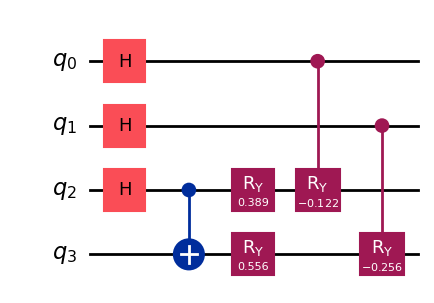

Quantum Statevector:
 Statevector([ 0.35232781+0.j,  0.34987447+0.j,  0.35320309+0.j,
              0.3535048 +0.j, -0.02941279+0.j, -0.05087098+0.j,
              0.01573468+0.j, -0.00586119+0.j,  0.02941279+0.j,
              0.05087098+0.j, -0.01573468+0.j,  0.00586119+0.j,
              0.35232781+0.j,  0.34987447+0.j,  0.35320309+0.j,
              0.3535048 +0.j],
            dims=(2, 2, 2, 2))
v = 0.45, p1 → θ = 0.482350 rad
v = 0.45, p2 → θ = 0.328738 rad
v = 0.45, p3 → θ = 0.701278 rad
v = 0.45, p4 → θ = 0.370086 rad
DensityMatrix([[ 0.4937742 +0.j, -0.03190457+0.j,  0.03190457+0.j,
                 0.4937742 +0.j],
               [-0.03190457+0.j,  0.0062258 +0.j, -0.0062258 +0.j,
                -0.03190457+0.j],
               [ 0.03190457+0.j, -0.0062258 +0.j,  0.0062258 +0.j,
                 0.03190457+0.j],
               [ 0.4937742 +0.j, -0.03190457+0.j,  0.03190457+0.j,
                 0.4937742 +0.j]],
              dims=(2, 2))


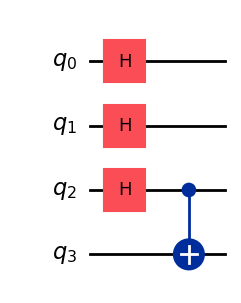

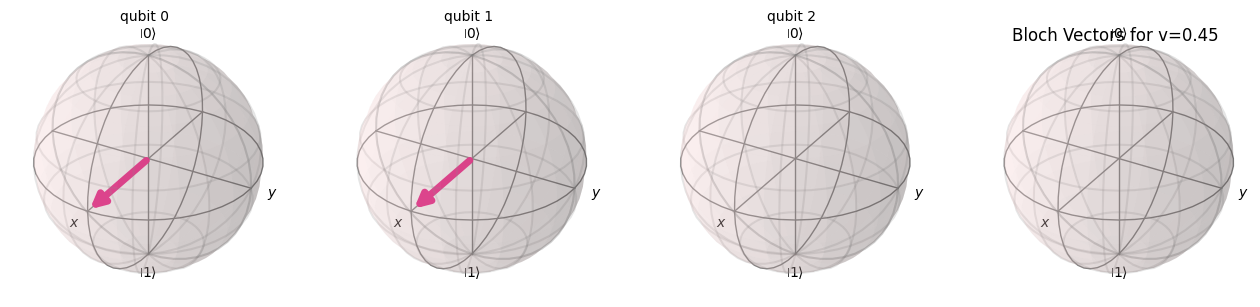

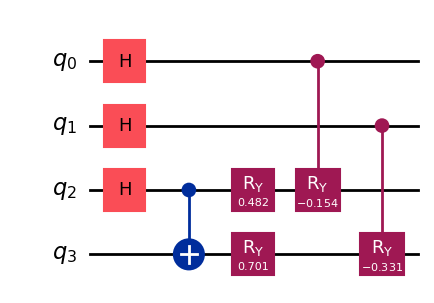

Quantum Statevector:
 Statevector([ 0.3514373 +0.j,  0.34743759+0.j,  0.35299655+0.j,
              0.35347784+0.j, -0.03862411+0.j, -0.06547612+0.j,
              0.01983518+0.j, -0.00730881+0.j,  0.03862411+0.j,
              0.06547612+0.j, -0.01983518+0.j,  0.00730881+0.j,
              0.3514373 +0.j,  0.34743759+0.j,  0.35299655+0.j,
              0.35347784+0.j],
            dims=(2, 2, 2, 2))
v = 0.55, p1 → θ = 0.563426 rad
v = 0.55, p2 → θ = 0.381966 rad
v = 0.55, p3 → θ = 0.831016 rad
v = 0.55, p4 → θ = 0.430509 rad
DensityMatrix([[ 0.49095451+0.j, -0.03840723+0.j,  0.03840723+0.j,
                 0.49095451+0.j],
               [-0.03840723+0.j,  0.00904549+0.j, -0.00904549+0.j,
                -0.03840723+0.j],
               [ 0.03840723+0.j, -0.00904549+0.j,  0.00904549+0.j,
                 0.03840723+0.j],
               [ 0.49095451+0.j, -0.03840723+0.j,  0.03840723+0.j,
                 0.49095451+0.j]],
              dims=(2, 2))


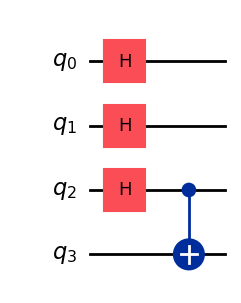

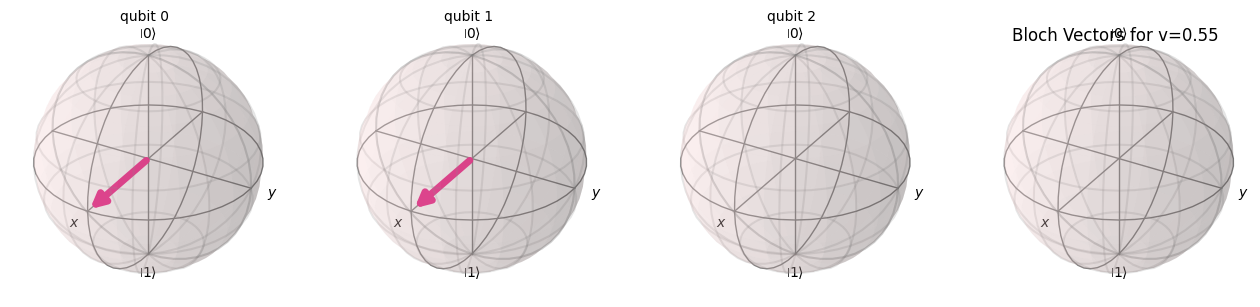

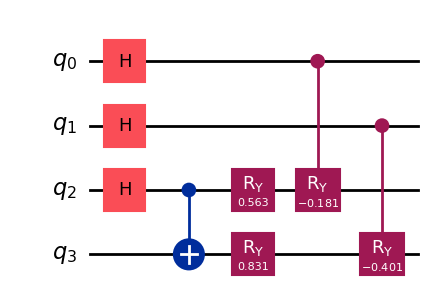

Quantum Statevector:
 Statevector([ 0.35039361+0.j,  0.34467918+0.j,  0.3527729 +0.j,
              0.35344926+0.j, -0.0471627 +0.j, -0.07871634+0.j,
              0.02347939+0.j, -0.00858038+0.j,  0.0471627 +0.j,
              0.07871634+0.j, -0.02347939+0.j,  0.00858038+0.j,
              0.35039361+0.j,  0.34467918+0.j,  0.3527729 +0.j,
              0.35344926+0.j],
            dims=(2, 2, 2, 2))
v = 0.66, p1 → θ = 0.634556 rad
v = 0.66, p2 → θ = 0.428411 rad
v = 0.66, p3 → θ = 0.946647 rad
v = 0.66, p4 → θ = 0.483294 rad
DensityMatrix([[ 0.48796652+0.j, -0.04416038+0.j,  0.04416038+0.j,
                 0.48796652+0.j],
               [-0.04416038+0.j,  0.01203348+0.j, -0.01203348+0.j,
                -0.04416038+0.j],
               [ 0.04416038+0.j, -0.01203348+0.j,  0.01203348+0.j,
                 0.04416038+0.j],
               [ 0.48796652+0.j, -0.04416038+0.j,  0.04416038+0.j,
                 0.48796652+0.j]],
              dims=(2, 2))


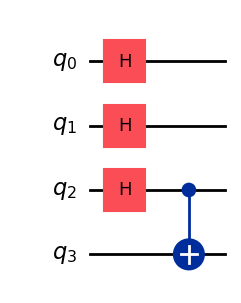

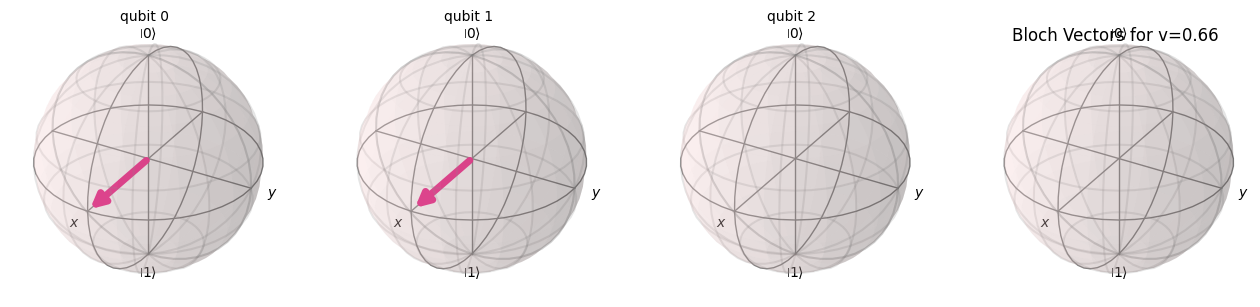

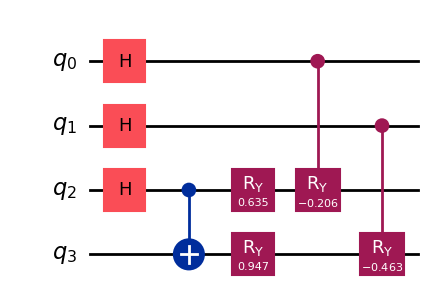

Quantum Statevector:
 Statevector([ 0.34925758+0.j,  0.34175051+0.j,  0.3525427 +0.j,
              0.35342028+0.j, -0.0549467 +0.j, -0.09059024+0.j,
              0.02671417+0.j, -0.00970077+0.j,  0.0549467 +0.j,
              0.09059024+0.j, -0.02671417+0.j,  0.00970077+0.j,
              0.34925758+0.j,  0.34175051+0.j,  0.3525427 +0.j,
              0.35342028+0.j],
            dims=(2, 2, 2, 2))
v = 0.77, p1 → θ = 0.697313 rad
v = 0.77, p2 → θ = 0.469250 rad
v = 0.77, p3 → θ = 1.049693 rad
v = 0.77, p4 → θ = 0.529741 rad
DensityMatrix([[ 0.48493357+0.j, -0.04919958+0.j,  0.04919958+0.j,
                 0.48493357+0.j],
               [-0.04919958+0.j,  0.01506643+0.j, -0.01506643+0.j,
                -0.04919958+0.j],
               [ 0.04919958+0.j, -0.01506643+0.j,  0.01506643+0.j,
                 0.04919958+0.j],
               [ 0.48493357+0.j, -0.04919958+0.j,  0.04919958+0.j,
                 0.48493357+0.j]],
              dims=(2, 2))


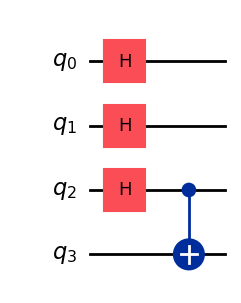

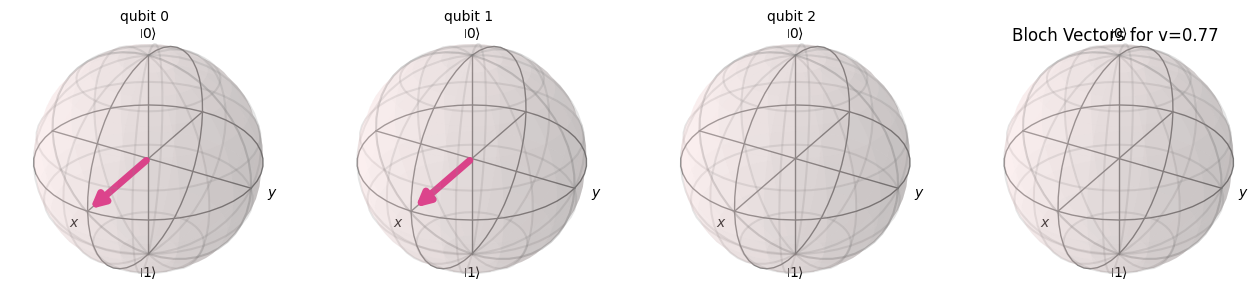

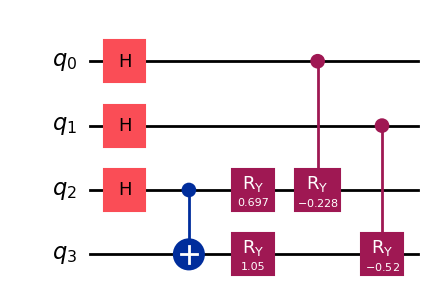

Quantum Statevector:
 Statevector([ 0.3480799 +0.j,  0.33876795+0.j,  0.35231313+0.j,
              0.35339169+0.j, -0.06197081+0.j, -0.10117448+0.j,
              0.02958813+0.j, -0.01069184+0.j,  0.06197081+0.j,
              0.10117448+0.j, -0.02958813+0.j,  0.01069184+0.j,
              0.3480799 +0.j,  0.33876795+0.j,  0.35231313+0.j,
              0.35339169+0.j],
            dims=(2, 2, 2, 2))
v = 0.88, p1 → θ = 0.752989 rad
v = 0.88, p2 → θ = 0.505412 rad
v = 0.88, p3 → θ = 1.141639 rad
v = 0.88, p4 → θ = 0.570886 rad
DensityMatrix([[ 0.48194296+0.j, -0.05358959+0.j,  0.05358959+0.j,
                 0.48194296+0.j],
               [-0.05358959+0.j,  0.01805704+0.j, -0.01805704+0.j,
                -0.05358959+0.j],
               [ 0.05358959+0.j, -0.01805704+0.j,  0.01805704+0.j,
                 0.05358959+0.j],
               [ 0.48194296+0.j, -0.05358959+0.j,  0.05358959+0.j,
                 0.48194296+0.j]],
              dims=(2, 2))


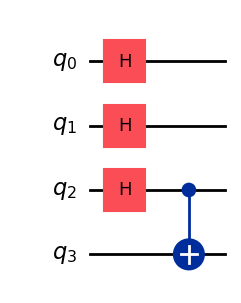

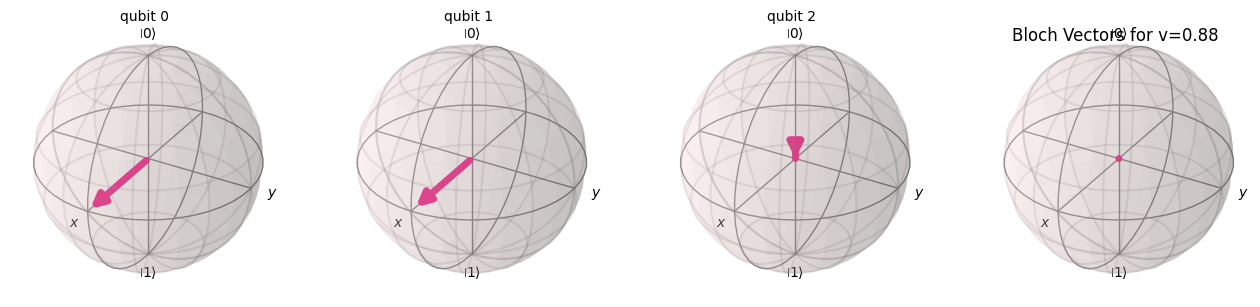

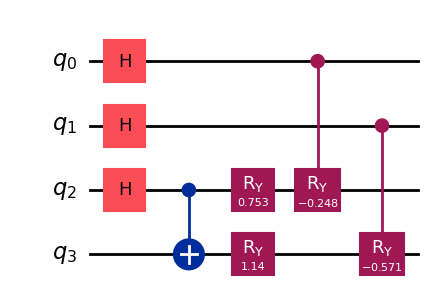

Quantum Statevector:
 Statevector([ 0.34689892+0.j,  0.33581461+0.j,  0.35208886+0.j,
              0.35336395+0.j, -0.06827255+0.j, -0.11058276+0.j,
              0.03214711+0.j, -0.01157234+0.j,  0.06827255+0.j,
              0.11058276+0.j, -0.03214711+0.j,  0.01157234+0.j,
              0.34689892+0.j,  0.33581461+0.j,  0.35208886+0.j,
              0.35336395+0.j],
            dims=(2, 2, 2, 2))
v = 0.99, p1 → θ = 0.802646 rad
v = 0.99, p2 → θ = 0.537636 rad
v = 0.99, p3 → θ = 1.223853 rad
v = 0.99, p4 → θ = 0.607558 rad
DensityMatrix([[ 0.47905197+0.j, -0.05740564+0.j,  0.05740564+0.j,
                 0.47905197+0.j],
               [-0.05740564+0.j,  0.02094803+0.j, -0.02094803+0.j,
                -0.05740564+0.j],
               [ 0.05740564+0.j, -0.02094803+0.j,  0.02094803+0.j,
                 0.05740564+0.j],
               [ 0.47905197+0.j, -0.05740564+0.j,  0.05740564+0.j,
                 0.47905197+0.j]],
              dims=(2, 2))


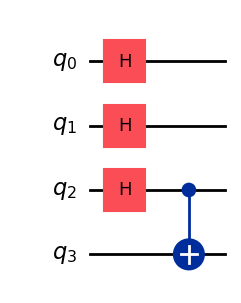

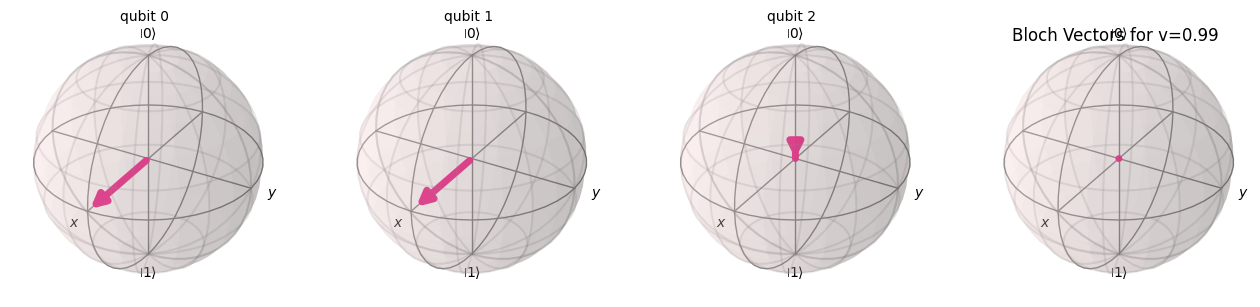

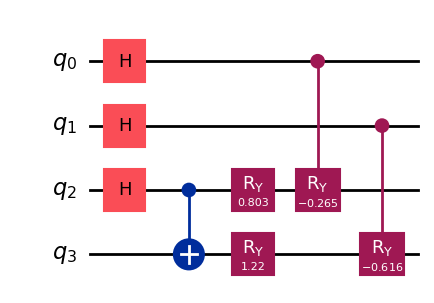

Quantum Statevector:
 Statevector([ 0.3457416 +0.j,  0.33294598+0.j,  0.35187273+0.j,
              0.35333734+0.j, -0.07391041+0.j, -0.11894104+0.j,
              0.0344323 +0.j, -0.01235809+0.j,  0.07391041+0.j,
              0.11894104+0.j, -0.0344323 +0.j,  0.01235809+0.j,
              0.3457416 +0.j,  0.33294598+0.j,  0.35187273+0.j,
              0.35333734+0.j],
            dims=(2, 2, 2, 2))


ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

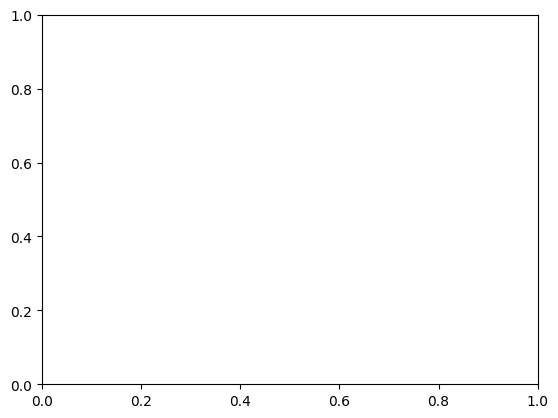

In [119]:
# Normalize vectors
for key in momentum_vectors:
    momentum_vectors[key] /= np.linalg.norm(momentum_vectors[key])
# Store circuits and statevectors
circuit_list = []
rapidity = []
# Iterate over velocities
for v in velocities:
    eta = np.arctanh(v)
    rapidity.append(eta)
    # Calculate Wigner angles for each momentum
    wigner_angles = {}
    for label, p_vec in momentum_vectors.items():
        cos_alpha = np.dot(boost_direction, p_vec)
        sin_alpha = np.sqrt(1 - cos_alpha ** 2)
        theta = 2 * np.arctan2(np.sinh(eta) * sin_alpha,
                               np.cosh(eta) + np.sinh(eta) * cos_alpha)
        wigner_angles[label] = theta
        print(f"v = {v:.2f}, {label} → θ = {theta:.6f} rad")
    # --- Build circuit ---
    qc = QuantumCircuit(4)  # [0,1]: momentum A,B | [2,3]: spin A,B

    # Step 1: Put momentum qubits in superposition
    qc.h(0)
    qc.h(1)

    # Step 2: Create Bell state between spin qubits
    qc.h(2)
    qc.cx(2, 3)
    qc.draw(output="mpl")
    # Step 3: Apply base Wigner rotation to spin qubits
    qc.ry(wigner_angles['p1'], 2)  # spin A
    qc.ry(wigner_angles['p3'], 3)  # spin B
    # Step 4: Controlled rotations based on momentum qubits
    delta_A = wigner_angles['p2'] - wigner_angles['p1']
    delta_B = wigner_angles['p4'] - wigner_angles['p3']
    qc.cry(delta_A, 0, 2)
    qc.cry(delta_B, 1, 3)
    state = Statevector.from_instruction(qc)
    reduced_spin = partial_trace(state, [0, 1])
    print(reduced_spin)
    S = entropy(reduced_spin, base=2)
    entropies.append(S)
    c = concurrence(reduced_spin)
    concurrence_values.append(c)

    # Store results
    circuit_list.append((v, qc.copy(), state))
    final_state = circuit_list[-1][2]
    plot_bloch_multivector(final_state)
    plt.title(f'Bloch Vectors for v={circuit_list[-1][-0]:.2f}')
    plt.show()
    qc.draw(output = "mpl")
    plt.show()
    print("Quantum Statevector:\n", state)

plt.plot(velocities, concurrence_values, marker='o')
plt.xlabel('Velocity')
plt.ylabel('Spin Concurrence')
plt.title('Spin-Spin Concurrence vs Velocity')
plt.grid(True)
plt.show()

plt.plot(rapidity, concurrence_values, marker='o')
plt.xlabel('rapidity')
plt.ylabel('Spin Concurrence')
plt.title('Spin-Spin Concurrence vs rapidity')
plt.grid(True)
plt.show()

plt.plot(velocities, entropies, color='darkblue')
plt.xlabel("Boost velocity v (as fraction of c)")
plt.ylabel("Von Neumann Entropy (Spin)")
plt.title("Entanglement between Spin and Momentum vs Velocity")
plt.grid(True)
plt.show()
qc.draw(output = "mpl")

## 